In [1]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
from keras.models import Sequential

# The following contain functions that are specific to Convolutional Networks.
from keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D, Dropout

# RMSprop is a type of optimizer.
from keras.optimizers import RMSprop

from keras.datasets import mnist, cifar10
from keras.utils import np_utils

from keras import initializers

# Backend can either be 'tensorflow' or 'theano'.
from keras import backend as K

import matplotlib.pyplot as plt

### MNIST

In [59]:
# Model Parameters.
batch_size = 128
nb_classes = 10
nb_epoch = 10

In [60]:
img_rows, img_cols = 28, 28         # input image dimensions
pool_size = (2, 2)                  # size of pooling area for max pooling
prob_drop_conv = 0.2                # drop probability for dropout @ conv layer
prob_drop_hidden = 0.5              # drop probability for dropout @ fc layer

In [61]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('X_train original shape:', X_train.shape)

# # The following needs to be done, because the order of dimensions are different in theano and tensorflow.
# if K.image_dim_ordering() == 'th':
#     # For Theano backend
#     X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
#     X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     # For TensorFlow backend
#     X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
#     X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)

X_train original shape: (60000, 28, 28)


In [62]:
# For TensorFlow backend
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [63]:
# Normalizing the input data.
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Conversion to one-hot encoding of the class vectors.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


#### Visualize

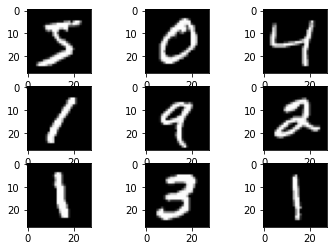

In [38]:
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i].reshape((28,28)), cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [64]:
input_shape

(28, 28, 1)

In [8]:
# Building the Convolutional Model
model = Sequential()

# Conv1 layer
model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu', input_shape=input_shape,\
                        init=initializers.normal()))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), border_mode='same'))
model.add(Dropout(prob_drop_conv))

# Conv2 layer
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', init=initializers.normal()))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), border_mode='same'))
model.add(Dropout(prob_drop_conv))

# Conv3 layer
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', init=initializers.normal()))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), border_mode='same'))
model.add(Flatten())
model.add(Dropout(prob_drop_conv))

# While building any convolutional networks, you should add a couple of dense layers at the end of the network.
# FC1 layer
model.add(Dense(625, activation='relu', init=initializers.normal()))
model.add(Dropout(prob_drop_hidden))

# The last layer of the classifier mostly has a 'softmax' activation unit, to get the probabilities.
# FC2 layer
model.add(Dense(10, activation='softmax', init=initializers.normal()))

# Declaring a separate object for the optimizer.
opt = RMSprop(lr=0.001, rho=0.9)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

**The conv layer**  
Accepts a volume of size $W_{1} \times H_{1} \times D_{1}$.  
  
Requires 4 hyperparameters:  
(1) Number of filters, $K$.  
(2) Their spatial extent, $F$.  
(3) Stride, $S$.  
(4) Amount of zero-padding, $P$.  
  
Produces a volume of size $W_{2} \times H_{2} \times D_{2}$.  
  
$W_{2} = \frac{(W_{1} - F + 2P)}{S} + 1$  
$H_{2} = \frac{(H_{1} - F + 2P)}{S} + 1$  
$D_{2} = K$  


**The number of parameters for a convolutional layer can be computed as follows :** 
$$
    ((n*m*D)+1) * K
$$
where,  
$n,m$ : Dimensions of the filter that you applied at that layer.  
$D$   : Depth of the input volume.  
$K$   : Number of filters that you apply at the convolutional layer.  

In [9]:
# conv2d_1 layer params : ( ((3*3*1)+1)*32 ) # 320
# conv2d_2 layer params : ( ((3*3*32)+1)*64 ) # 18496
# conv2d_3 layer params : ( ((3*3*64)+1)*128 ) # 73856
# dense_1 layer params  : (2048*625)+625) # 1280625
# dense_2 layer params  : ((625*10)+10) # 6260 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)        

In [10]:
# Train
history = model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=batch_size, shuffle=True, verbose=1)


Epoch 1/10
60000/60000 [==============================] - 20s 336us/step - loss: 0.2565 - accuracy: 0.9172
Epoch 2/10
60000/60000 [==============================] - 19s 323us/step - loss: 0.0716 - accuracy: 0.9777
Epoch 3/10
60000/60000 [==============================] - 21s 344us/step - loss: 0.0524 - accuracy: 0.9836
Epoch 4/10
60000/60000 [==============================] - 18s 294us/step - loss: 0.0449 - accuracy: 0.9860
Epoch 5/10
60000/60000 [==============================] - 15s 256us/step - loss: 0.0404 - accuracy: 0.9869
Epoch 6/10
60000/60000 [==============================] - 15s 256us/step - loss: 0.0347 - accuracy: 0.9894
Epoch 7/10
60000/60000 [==============================] - 15s 255us/step - loss: 0.0323 - accuracy: 0.9898
Epoch 8/10
60000/60000 [==============================] - 15s 256us/step - loss: 0.0314 - accuracy: 0.9905
Epoch 9/10
60000/60000 [==============================] - 15s 257us/step - loss: 0.0294 - accuracy: 0.9911
Epoch 10/10
60000/60000 [===========

In [ ]:
model.predict()

In [11]:
# Evaluate
evaluation = model.evaluate(X_test, Y_test, batch_size=256, verbose=1)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

10000/10000 [==============================] - 0s 47us/step
Summary: Loss over the test dataset: 0.02, Accuracy: 0.99


### CIFAR10

In [47]:
# Model Parameters.
batch_size = 128
nb_classes = 10
nb_epoch = 10

In [48]:
img_rows, img_cols = 32, 32         # input image dimensions
pool_size = (2, 2)                  # size of pooling area for max pooling
prob_drop_conv = 0.2                # drop probability for dropout @ conv layer
prob_drop_hidden = 0.5              # drop probability for dropout @ fc layer

In [49]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train original shape:', X_train.shape)

# # The following needs to be done, because the order of dimensions are different in theano and tensorflow.
# if K.image_dim_ordering() == 'th':
#     # For Theano backend
#     X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
#     X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     # For TensorFlow backend
#     X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
#     X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)

X_train original shape: (50000, 32, 32, 3)


In [50]:
# For TensorFlow backend
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)

In [51]:
# Normalizing the input data.
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Conversion to one-hot encoding of the class vectors.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [52]:
# Building the Convolutional Model
model = Sequential()

# Conv1 layer
model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu', input_shape=input_shape,\
                        init=initializers.normal()))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), border_mode='same'))
model.add(Dropout(prob_drop_conv))

# Conv2 layer
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', init=initializers.normal()))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), border_mode='same'))
model.add(Dropout(prob_drop_conv))

# Conv3 layer
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', init=initializers.normal()))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), border_mode='same'))
model.add(Flatten())
model.add(Dropout(prob_drop_conv))

# While building any convolutional networks, you should add a couple of dense layers at the end of the network.
# FC1 layer
model.add(Dense(625, activation='relu', init=initializers.normal()))
model.add(Dropout(prob_drop_hidden))

# The last layer of the classifier mostly has a 'softmax' activation unit, to get the probabilities.
# FC2 layer
model.add(Dense(10, activation='softmax', init=initializers.normal()))

# Declaring a separate object for the optimizer.
opt = RMSprop(lr=0.001, rho=0.9)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

The number of parameters for a convolutional layer can be computed as follows : 
$$
    ((n*m*D)+1) * K
$$
where,  
$n,m$ : Dimensions of the filter that you applied at that layer.  
$D$   : Depth of the input volume.  
$K$   : Number of filters that you apply at the convolutional layer.  

In [53]:
# conv2d_1 layer params : ( ((3*3*3)+1)*32 ) # 
# conv2d_2 layer params : ( ((3*3*32)+1)*64 ) # 18496
# conv2d_3 layer params : ( ((3*3*64)+1)*128 ) # 73856
# dense_1 layer params  : (2048*625)+625) # 1280625
# dense_2 layer params  : ((625*10)+10) # 6260 
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 128)        

In [54]:
# Train
history = model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=batch_size, shuffle=True, verbose=1)

Epoch 1/10
50000/50000 [==============================] - 16s 330us/step - loss: 1.7703 - accuracy: 0.3578
Epoch 2/10
50000/50000 [==============================] - 16s 328us/step - loss: 1.3704 - accuracy: 0.5110
Epoch 3/10
50000/50000 [==============================] - 16s 327us/step - loss: 1.1729 - accuracy: 0.5859
Epoch 4/10
50000/50000 [==============================] - 16s 325us/step - loss: 1.0451 - accuracy: 0.6321
Epoch 5/10
50000/50000 [==============================] - 16s 327us/step - loss: 0.9613 - accuracy: 0.6611
Epoch 6/10
50000/50000 [==============================] - 16s 326us/step - loss: 0.8977 - accuracy: 0.6868
Epoch 7/10
50000/50000 [==============================] - 16s 326us/step - loss: 0.8455 - accuracy: 0.7042
Epoch 8/10
50000/50000 [==============================] - 16s 325us/step - loss: 0.8106 - accuracy: 0.7200
Epoch 9/10
50000/50000 [==============================] - 16s 325us/step - loss: 0.7742 - accuracy: 0.7304
Epoch 10/10
50000/50000 [============

In [55]:
# Evaluate
evaluation = model.evaluate(X_test, Y_test, batch_size=256, verbose=1)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

10000/10000 [==============================] - 1s 80us/step
Summary: Loss over the test dataset: 0.84, Accuracy: 0.71
